# Import dependencies

1. Descargamos las librerías necesarias para la realización del script:

In [1]:
#Descargamos la libreria de transformers que usaremos para descargar el modelo como su respectivo tokenizador
!pip  install transformers --quiet
!pip install Datasets --quiet
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.0 MB/s eta 0:00:00


In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 2. Importamos el dataset

In [4]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Mounted at /content/drive


In [5]:
df.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,es,Nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
1,EXIST2021,2,twitter,es,"@lindagisela74 Que rica putita obediente, afor...",sexist,stereotyping-dominance
2,EXIST2021,3,twitter,es,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,non-sexist
3,EXIST2021,4,twitter,es,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
4,EXIST2021,5,twitter,es,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,non-sexist


In [6]:
# 2. Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task2']
df = df.rename(columns = {"task1": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexist
1,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [7]:
#3. Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexist'],[0, 1])

In [8]:
#4. Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()

In [9]:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",1
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


### 2.1 - *Separamos el dataset en varios conjuntos (Train, Validación y Test)*

In [10]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [11]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [12]:
#Lo convertimos en un solo dataset:

tweets = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

tweets = tweets.remove_columns(["__index_level_0__"])

In [13]:
tweets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

### 3 - Descarga del modelo y su tokenizador:

In [14]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "distilbert-base-uncased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=512, truncation = True)

In [16]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
tweets_Encoded = tweets.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [17]:
tweets_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [18]:
#Ahora que hemos codificado el texto, lo eliminamos de nuestro diccionarios ya que no es necesario:
#tweets_Encoded = tweets_Encoded.remove_columns(['text'])

In [19]:
#Necesitamos que los objetos sean de tipo torch
tweets_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [20]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['Sexista','No_Sexista']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'Sexista', '1': 'No_Sexista'}, {'Sexista': '0', 'No_Sexista': '1'})

In [22]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4. Definimos los hyperparametros:

In [26]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [23]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [27]:
# Entrenemos el modelo con la API Trainer:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = tweets_Encoded["train"],
  eval_dataset = tweets_Encoded["val"],
  tokenizer = tokenizer)

In [29]:
gc.collect()
torch.cuda.empty_cache()

In [30]:
#5.Entrenamos nuestro modelo:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.625600,0.584503,0.704325,0.702492
2,0.533900,0.575672,0.727273,0.724207
3,0.435100,0.601427,0.736099,0.734820


TrainOutput(global_step=3399, training_loss=0.5323794825913871, metrics={'train_runtime': 1528.9565, 'train_samples_per_second': 17.783, 'train_steps_per_second': 2.223, 'total_flos': 3601656102057984.0, 'train_loss': 0.5323794825913871, 'epoch': 3.0})

### Matriz de Confusión

In [31]:
preds_output = trainer.predict(tweets_Encoded["val"])

In [32]:
preds_output.metrics

{'test_loss': 0.5756718516349792,
 'test_accuracy': 0.7272727272727273,
 'test_f1': 0.7242074042338148,
 'test_runtime': 6.7438,
 'test_samples_per_second': 168.007,
 'test_steps_per_second': 21.057}

Text(0.5, 1.0, 'Matriz de confusión')

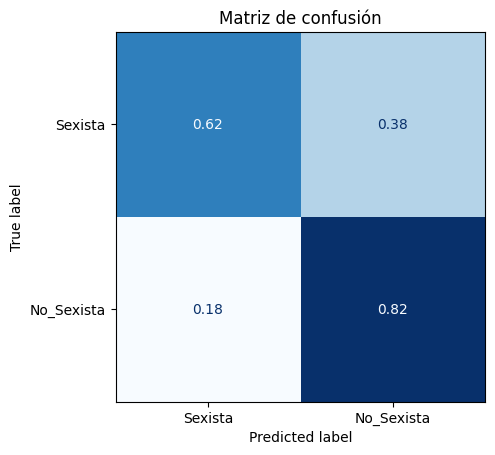

In [33]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(tweets_Encoded["val"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

In [34]:
preds_output = trainer.predict(tweets_Encoded["test"])
preds_output.metrics



{'test_loss': 0.5825808644294739,
 'test_accuracy': 0.7140335392762577,
 'test_f1': 0.7110389797250704,
 'test_runtime': 11.2915,
 'test_samples_per_second': 100.341,
 'test_steps_per_second': 12.576}

Text(0.5, 1.0, 'Matriz de confusión')

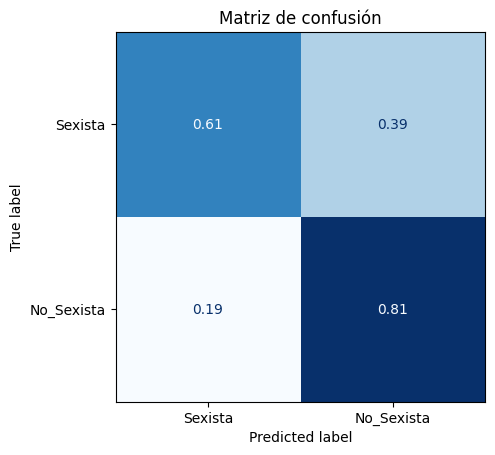

In [35]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(tweets_Encoded["test"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

# Guardamos el modelo:


In [36]:
model.save_pretrained(
  os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))

('/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/vocab.txt',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/added_tokens.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer.json')

# Análisis del validation loss

In [37]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [38]:
tweets_Encoded["val"] = tweets_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [39]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [40]:
tweets_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tweets_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [47]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)

In [48]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
29,"@IanRGillespie @jessesingal OG gamergate feminismo ya no se despierta, en realidad, lo considero reaccionario, por no centrar adecuadamente las voces trans WoC.Así que Valenti es un chud de derecha.",No_Sexista,Sexista,3.169923
72,idc lo que todo el mundo dice misandry es islámico que promueve el hiyab,No_Sexista,Sexista,3.045156
778,"¡Epítome de la hipocresía! La propia Cynthia ha presentado cargos contra el ex ministro del interior, pero este feminazi no la defiende. Probablemente porque:Cynthia no es una mujer a sus ojos o su mentalidad líbilda se niega a creer que RM podría hacer tal cosa#patética https://t.co/jNiIAIBfe6",Sexista,No_Sexista,2.997995
440,"@NauterFuck @ElNismeado @ZoeZiacok @DarkRonny23 No pero la mayoria de los hombres lo son. Ademas yo vivo repitiendo en los comentarios que no lo son todos. Pero bueno, se agarran siempre de la misma pelotudez",No_Sexista,Sexista,2.966172
759,"Miren este relato de terror. Un poco tedioso, pero con un final esperado, donde vemos que el 99.99% de las tías son este tipo de criatura. El cazarrecompensas se tragó la píldora azul, yo paso... #mgtow@pokasoltesagain @L0Bo_S0litari0 https://t.co/piDLm29X50",No_Sexista,Sexista,2.943752
1081,"Quién les hizo tanto daño Una habla de #NiUnaMenos o #MeToo, pero a estos batos lo peor que les puede pasar es no tener ligues. Bola de pendejos. https://t.co/5RnZea5J9K",No_Sexista,Sexista,2.859760
930,@NinjaSocialist @BynameRose @Ponder_O_Purg @GameOverRos @natsprat3 @annaeck73 @shahjoffe @OustideVoice @EXPELincels @Elfskin7 @CrossBidy @Holdenheim1 @3nigmatic_01 @jools6691 @KRblx123 @blackishmonday @SuperRealScott @beeonroids @GreatMi64424995 @SR_Duncan @j_bbrav0 @TwitchyMac @DredSadie @MgtowRadical @FCDaran @KLKnight81 @AvaGraceVip @Lecanardnoir @Falconer084 @TwenGrit @Kafi @MedusaHypatyPatyPatia @sandsquist@Gen@Gen@Gen@Gen@Gen@G,No_Sexista,Sexista,2.752857
595,"la gente realmente piensa que pueden joder conmigo, perra no soy tonto no dejes que la rubia te engañe",Sexista,No_Sexista,2.752631
61,@swansitions No podemos stanear a varones por que si no nos gusta ver a las mujeres triunfar y somos menos feministas,Sexista,No_Sexista,2.746094
880,"Ustedes, perras, necesitan un chequeo de la realidad.",No_Sexista,Sexista,2.735648


In [49]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
95,El público tiene derecho a la mayor cantidad de información posible para juzgar la fiabilidad y motivaciones de las fuentes. #gamergate,Sexista,Sexista,0.036072
508,Considere las diferencias culturales en el enfoque y el tratamiento. #gamergate,Sexista,Sexista,0.037609
257,Recuerde que ni la velocidad ni el formato excusa inexactitud. #gamergate,Sexista,Sexista,0.038066
805,"Tim Schafer en #GamerGate: ""Fue una época muy enojada en la cultura del juego y salí de ella bloqueando a 11.000 personas en Twitter... Y por suerte, esas personas se pusieron a moverse para dirigir el gobierno de los Estados Unidos"". https://t.co/Sp5AUNnUya",Sexista,Sexista,0.038125
776,La obligación más alta y principal del periodismo ético es servir al público. #gamergate,Sexista,Sexista,0.038371
240,Japón le da a Xbox Series X el FINGER! Microsoft va FULL Puritan! https://t.co/oAc1XMMYd2 vía @YouTube,Sexista,Sexista,0.039450
562,¿Dónde están los patriotas corporativos?El Señor Presidente Trump también merece elogios por exponer la mano oculta de Pekín en el robo de tecnología y propiedad intelectual de Estados Unidos.https://www.wsj.com/articles/where-are-the-corporate-patriots-1543447418,Sexista,Sexista,0.041255
327,"Todo el mundo, por favor escuchen, estoy enamorado de Changbin, tengo un gran enamoramiento gordo en Changbin /hj",Sexista,Sexista,0.045409
1041,Hasta una feminazi se va a dejar maltratar por un hombre a la hora de coger porque cuando una mujer anda con ganas de que le metan la verga se olvida de cualquier ideal o principio hasta que se le baje la calentura #Educandoalaputeria,No_Sexista,No_Sexista,0.045502
321,"En los últimos años, Rusia ha sido escenario de varios de los juicios por asesinatos en serie con más víctimas en el mundo, incluyendo un caso con 78 víctimas, y otro con 48. https://t.co/gU0tPutbdc",Sexista,Sexista,0.045763
